In [5]:

# Import required libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully!")


Matplotlib is building the font cache; this may take a moment.


Libraries imported successfully!


In [12]:
import tensorflow as tf

# Correct path to dataset
data_dir = r"/Users/imeshaaluvihare/Desktop/Research/Identify Diseases for Lavender plant/Model Training LeafDisease & InsectDiseas/leaf_dataset"

# Image preprocessing parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Split dataset into training & validation sets (80% / 20%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="binary",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print("Class names:", train_ds.class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 79128 files belonging to 2 classes.
Using 63303 files for training.


2025-11-30 00:51:42.503243: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-30 00:51:42.503449: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-30 00:51:42.503465: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-30 00:51:42.503720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-30 00:51:42.503979: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 79128 files belonging to 2 classes.
Using 15825 files for validation.
Class names: ['diseased', 'healthy']


In [16]:
# Import TensorFlow Keras modules
from tensorflow import keras
from tensorflow.keras import layers


#Data Augmentation

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),       # Flip images horizontally
        layers.RandomRotation(0.15),          # Rotate images slightly
        layers.RandomZoom(0.2),               # Zoom in/out randomly
        layers.RandomTranslation(0.05, 0.05), # Shift images slightly
    ],
    name="data_augmentation",
)


# Load Pretrained MobileNetV2 Base Model
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),  # Input image size (height, width, channels)
    include_top=False,            # Exclude the final classification layer
    weights="imagenet",           # Load pretrained weights
    alpha=0.75                    # Reduce model size (smaller/lighter)
)

base_model.trainable = False


#Build Full Model

inputs = keras.Input(shape=IMG_SIZE + (3,))  # Input layer
x = data_augmentation(inputs)                # Apply data augmentation
x = keras.applications.mobilenet_v2.preprocess_input(x)  # Preprocess for MobileNetV2
x = base_model(x, training=False)            # Pass through base model
x = layers.GlobalAveragePooling2D()(x)      # Reduce dimensions
x = layers.Dropout(0.3)(x)                  # Add dropout
outputs = layers.Dense(1, activation="sigmoid")(x)  # Output layer

model = keras.Model(inputs, outputs)        # Create model


# Compile Model

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#Model Summary
model.summary()  # Print model architecture


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.75_160            │ (None, 5, 5, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,383,345 (5.28 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 1,382,064 (5.27 MB)

In [17]:

# Import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor="val_loss",    # Monitor validation loss
        patience=5,            # Stop after 5 epochs of no improvement
        restore_best_weights=True  # Restore the best model
    )
]

#Train the Model
EPOCHS = 10  

history = model.fit(
    train_ds,              # Training dataset
    validation_data=val_ds, # Validation dataset
    epochs=EPOCHS,
    callbacks=callbacks
)


# Training Complete

print("✅ Training complete!")


Epoch 1/10


2025-11-30 00:57:53.060592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-30 00:58:04.034316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 703 of 1000
2025-11-30 00:58:10.184056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 219s 99ms/step - accuracy: 0.8583 - loss: 0.3361 - val_accuracy: 0.9572 - val_loss: 0.1582
Epoch 2/10


2025-11-30 01:01:41.159613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 732 of 1000
2025-11-30 01:01:45.445679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 222s 103ms/step - accuracy: 0.9538 - loss: 0.1446 - val_accuracy: 0.9712 - val_loss: 0.1043
Epoch 3/10


2025-11-30 01:05:23.208295: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 735 of 1000
2025-11-30 01:05:27.279418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 216s 100ms/step - accuracy: 0.9643 - loss: 0.1098 - val_accuracy: 0.9755 - val_loss: 0.0830
Epoch 4/10


2025-11-30 01:08:59.183405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 788 of 1000
2025-11-30 01:09:02.459183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 208s 96ms/step - accuracy: 0.9708 - loss: 0.0911 - val_accuracy: 0.9787 - val_loss: 0.0714
Epoch 5/10


2025-11-30 01:12:26.871919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 798 of 1000
2025-11-30 01:12:29.932019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 211s 98ms/step - accuracy: 0.9730 - loss: 0.0818 - val_accuracy: 0.9807 - val_loss: 0.0638
Epoch 6/10


2025-11-30 01:15:58.074112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 775 of 1000
2025-11-30 01:16:01.451361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 211s 98ms/step - accuracy: 0.9749 - loss: 0.0767 - val_accuracy: 0.9822 - val_loss: 0.0578
Epoch 7/10


2025-11-30 01:19:29.172750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 796 of 1000
2025-11-30 01:19:32.382021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 208s 96ms/step - accuracy: 0.9746 - loss: 0.0737 - val_accuracy: 0.9831 - val_loss: 0.0541
Epoch 8/10


2025-11-30 01:22:57.171280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 726 of 1000
2025-11-30 01:23:02.655865: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 211s 97ms/step - accuracy: 0.9769 - loss: 0.0688 - val_accuracy: 0.9833 - val_loss: 0.0525
Epoch 9/10


2025-11-30 01:26:28.665906: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 774 of 1000
2025-11-30 01:26:32.149108: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 211s 98ms/step - accuracy: 0.9778 - loss: 0.0662 - val_accuracy: 0.9852 - val_loss: 0.0495
Epoch 10/10


2025-11-30 01:29:59.642008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:16: Filling up shuffle buffer (this may take a while): 733 of 1000
2025-11-30 01:30:05.349374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1979/1979 ━━━━━━━━━━━━━━━━━━━━ 211s 96ms/step - accuracy: 0.9771 - loss: 0.0657 - val_accuracy: 0.9846 - val_loss: 0.0481
✅ Training complete!


In [24]:
from tensorflow.keras.models import save_model

# Path where you want to save the model
save_path = r"/Users/imeshaaluvihare/Desktop/Research/Identify Diseases for Lavender plant/mylavender_model.keras"

# Save the model (architecture + weights + optimizer)
model.save(save_path)

print(f"✅ Model saved successfully at: {save_path}")


✅ Model saved successfully at: /Users/imeshaaluvihare/Desktop/Research/Identify Diseases for Lavender plant/mylavender_model.keras


In [25]:
from tensorflow.keras.models import load_model

# Path to your saved model
model_path = r"/Users/imeshaaluvihare/Desktop/Research/Identify Diseases for Lavender plant/mylavender_model.keras"

# Load the trained model
model = load_model(model_path)
print("✅ Model loaded successfully!")
model.summary()


✅ Model loaded successfully!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.75_160            │ (None, 5, 5, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385,909 (5.29 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 1,382,064 (5.27 MB)

 Optimizer params: 2,564 (10.02 KB)

Model loaded successfully!


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.75_160            │ (None, 5, 5, 1280)     │     1,382,064 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,385,909 (5.29 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 1,382,064 (5.27 MB)

 Optimizer params: 2,564 (10.02 KB)

Found 79128 files belonging to 2 classes.
Evaluation dataset ready!
Class names: ['diseased', 'healthy']
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 160s 62ms/step - accuracy: 0.9850 - loss: 0.0480

Model Accuracy: 98.50%
Model Loss    : 0.0480
2473/2473 ━━━━━━━━━━━━━━━━━━━━ 154s 61ms/step

Classification Report:
              precision    recall  f1-score   support

    diseased       0.98      0.99      0.99     51330
     healthy       0.99      0.97      0.98     27798

    accuracy                           0.98     79128
   macro avg       0.99      0.98      0.98     79128
weighted avg       0.99      0.98      0.98     79128



2025-11-30 02:04:37.272265: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


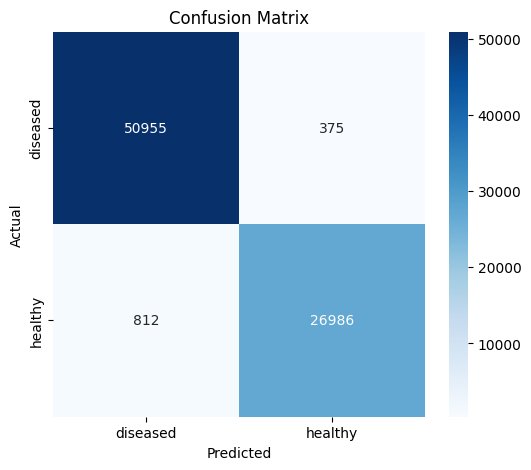

In [34]:

# Evaluation 

import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Paths and parameters
model_path = r"/Users/imeshaaluvihare/Desktop/Research/Identify Diseases for Lavender plant/mylavender_model.keras"
eval_data_dir = r"/Users/imeshaaluvihare/Desktop/Research/Identify Diseases for Lavender plant/Model Training LeafDisease & InsectDiseas/leaf_dataset"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

# Load the trained model
model = load_model(model_path)
print("Model loaded successfully!")
model.summary()

# Load evaluation dataset
eval_ds = tf.keras.utils.image_dataset_from_directory(
    eval_data_dir,
    labels="inferred",
    label_mode="binary",          
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False                 
)

print("Evaluation dataset ready!")
print("Class names:", eval_ds.class_names)

# Evaluate the model
loss, accuracy = model.evaluate(eval_ds)
print(f"\nModel Accuracy: {accuracy*100:.2f}%")
print(f"Model Loss    : {loss:.4f}")

# Predictions for classification report and confusion matrix
pred_probs = model.predict(eval_ds)
pred_classes = (pred_probs > 0.5).astype(int).ravel()
y_true = np.concatenate([y.numpy() for x, y in eval_ds], axis=0)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, pred_classes, target_names=eval_ds.class_names))

# Confusion matrix
cm = confusion_matrix(y_true, pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=eval_ds.class_names, yticklabels=eval_ds.class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
